In [1]:
import torch as t
from torch.utils import data

In [2]:
import os
from PIL import Image
import numpy as np

In [5]:
class DogCat(data.Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)
        # 所有图片的绝对路径
        # 这里不实际加载图片，只是指定路径，当调用__getitem__时才会真正读图片
        self.imgs = [os.path.join(root, img) for img in imgs]
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        # dog->1， cat->0
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, label
    
    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = DogCat('./data/dogcat/')
img, label = dataset[0] # 相当于调用dataset.__getitem__(0)
for img, label in dataset:
    print(img.size(), img.float().mean(), label)

# 用torchvision实现对PIL image和Tensor的常用操作 

In [45]:
import os
from PIL import Image
import numpy as np
from torchvision import transforms as T

In [11]:
transform = T.Compose([
    T.Resize(224),# 缩放图片(Image)，保持长宽比不变，最短边为224像素
    T.CenterCrop(224), # 从图片中间切出224*224的图片
    T.ToTensor(), #将图片(Image)转成Tensor，归一化至[0, 1]
    T.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])# 标准化至[-1, 1]，规定均值和标准差 
])

In [12]:
class DogCat(data.Dataset):
    def __init__(self,root,transforms=None):
        imgs = os.listdir(root) #得到在root下所有的images
        self.imgs = [os.path.join(root,img) for img in imgs] #建立images的path： root/image
        self.tranforms=transforms
        
    def __getitem__(self,index):
        img_path = self.imgs[index]
        label = 0 if 'dog' in img_path.split('/')[-1] else 1
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label
    
    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = DogCat('./data/dogcat',transforms = transform)
img, label = dataset[0]
for img,label in dataset:
    print(img.size(),label)

In [ ]:
from torchvision.datasets import imageFolder
dataset = ImageFolder('data/dogcat_2/')

In [ ]:
dataset.class_to_idx

In [ ]:
dataset.imgs

In [ ]:
# 没有任何的transform，所以返回的还是PIL Image对象
dataset[0][1] # 第一维是第几张图，第二维为1返回label
dataset[0][0] # 为0返回图片数据

In [ ]:
# 加上transform
normalize = T.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
transform  = T.Compose([
         T.RandomResizedCrop(224),
         T.RandomHorizontalFlip(),
         T.ToTensor(),
         normalize,
])

In [ ]:
dataset = ImageFolder('data/dogcat_2/', transform=transform)

In [ ]:
# 深度学习中图片数据一般保存成CxHxW，即通道数x图片高x图片宽
dataset[0][0].size()

# DataLoader

In [13]:
from torch.utils.data import DataLoader

In [ ]:
dataloader = DataLoader(dataset, batch_size=3,shuffle=True, num_workers=0,drop_last=False)

In [ ]:
dataiter = iter(dataloader)
imgs.labels = next(dataiter)
imgs.size()

In [14]:
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super(NewDogCat,self).__getitem__(index)
        except:
            return None, None

In [16]:
from torch.utils.data.dataloader import default_collate
def my_collate_fn(batch):
    '''
    batch中每个元素形如(data, label)
    '''
    # 过滤为None的数据
    batch = list(filter(lambda x:x[0] is not None, batch))
    if len(batch) == 0: return t.Tensor()
    return default_collate(batch) # 用默认方式拼接过滤后的batch数据

In [ ]:
dataset = NewDogCat('data/dogcat_wrong/', transforms=transform)

In [ ]:
dataloader = DataLoader(dataset, 2, collate_fn=my_collate_fn, num_workers=1,shuffle=True)
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(),batch_labels.size())

# 视觉工具包： torchvision 

In [18]:
from torchvision import models
from torch import nn

In [19]:
resnet34 = models.squeezenet1_1(pretrained=True, num_classes=1000)

resnet34.fc = nn.Linear(512,10)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to C:\Users\y63qiu/.cache\torch\checkpoints\squeezenet1_1-f364aa15.pth
100.0%


In [20]:
from torchvision import datasets
dataset = datasets.MNIST('data/', download=True, train=False, transform=transform)

0.0%

100.1%

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz


1.0%5%

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz


180.4%

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


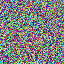

In [21]:
from torchvision import transforms
to_pil = transforms.ToPILImage()
to_pil(t.randn(3,64,64))

In [22]:
len(dataset)

10000

In [24]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)
from torchvision.utils import make_grid, save_image
dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0], 4) # 拼成4*4网格图片，且会转成３通道
to_img(img)

RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

# 可视化工具 

## Tensorboard 

In [26]:
from tensorboardX import SummaryWriter

In [27]:
# 构建logger对象，logdir用来指定log文件的保存路径
# flush_secs用来指定刷新同步间隔
logger = SummaryWriter(log_dir='experimient_cnn', flush_secs=2)

In [28]:
for ii in range(100):
    logger.add_scalar('data/loss',10-ii**0.5)
    logger.add_scalar('data/accuracy',ii**0.5/10)

## Visdom 

# GPU加速 

In [29]:
tensor = t.Tensor(3,4)

In [30]:
tensor = tensor.cuda()

In [31]:
tensor.is_cuda

True

In [32]:
module = nn.Linear(3,4)

In [33]:
module

Linear(in_features=3, out_features=4, bias=True)

In [34]:
module.cuda()

Linear(in_features=3, out_features=4, bias=True)

In [35]:
module.weight.is_cuda

True

In [36]:
class VeryBigModule(nn.Module):
    def __init__(self):
        super(veryBigModule,self).__init__()
        self.GiantParameter = t.nn.Parameter(t.randn(100000,20000)).cuda()
        
    def forward(self,x):
        x = self.GlantParameter1.mm(x.cuda())
        return x

In [37]:
# 交叉熵损失函数，带权重
criterion = t.nn.CrossEntropyLoss(weight=t.Tensor([1,3]))
input = t.randn(4,2).cuda()
target = t.Tensor([1,0,0,1]).long().cuda()

In [39]:
criterion.cuda()
loss = criterion(input,target)

In [40]:
criterion._buffers

OrderedDict([('weight', tensor([1., 3.], device='cuda:0'))])

In [42]:
import visdom

vis = visdom.Visdom(env=u'test1',use_incoming_socket=False)

Setting up a new session...
Traceback (most recent call last):
  File "C:\Users\y63qiu\AppData\Local\Continuum\anaconda3\envs\yorkml\lib\site-packages\requests\packages\urllib3\connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "C:\Users\y63qiu\AppData\Local\Continuum\anaconda3\envs\yorkml\lib\site-packages\requests\packages\urllib3\util\connection.py", line 83, in create_connection
    raise err
  File "C:\Users\y63qiu\AppData\Local\Continuum\anaconda3\envs\yorkml\lib\site-packages\requests\packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\y63qiu\AppData\Local\Continuum\anaconda3\envs\yorkml\lib\site-packages\requests\packages\urllib3\connectionpool.py", line 600, 

Exception in user code:
------------------------------------------------------------


In [ ]:
vis.line(X=x,Y=y,win='sinx',opts={'title':'y'})